# Logistics Analysis

### 1. Import Libraries

In [1]:
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import numpy as np

### 2. Load Data

In [2]:
# Extract ZIP file
zip_path = "Delhivery Logistics.zip"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall()

# Load dataset
df = pd.read_csv("delhivery.csv")
print("Dataset loaded successfully!")
print(df.head())

Dataset loaded successfully!
       data          trip_creation_time  \
0  training  2018-09-20 02:35:36.476840   
1  training  2018-09-20 02:35:36.476840   
2  training  2018-09-20 02:35:36.476840   
3  training  2018-09-20 02:35:36.476840   
4  training  2018-09-20 02:35:36.476840   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                 trip_uuid source_center                 source_name  \
0  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
1  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
2  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
3  trip-1537410936476

### 3. Data Cleaning

In [3]:
print("\nHandling missing values...")
# Fill missing categorical values with 'Unknown'
categorical_columns = ['source_name', 'destination_name']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

# Fill missing numerical values with median
numerical_columns = ['actual_distance_to_destination', 'actual_time', 'osrm_time']
df[numerical_columns] = df[numerical_columns].apply(lambda x: x.fillna(x.median()))

# Remove negative or unrealistic values
df = df[df['actual_time'] > 0]
df = df[df['actual_distance_to_destination'] > 0]
df = df[df['osrm_time'] > 0]

# Convert timestamps to datetime
df['start_time'] = pd.to_datetime(df['od_start_time'], errors='coerce')
df.dropna(subset=['start_time'], inplace=True)
df['hour'] = df['start_time'].dt.hour

print("Data Cleaning Completed!\n")
print(df.info())


Handling missing values...
Data Cleaning Completed!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  object        
 1   trip_creation_time              144867 non-null  object        
 2   route_schedule_uuid             144867 non-null  object        
 3   route_type                      144867 non-null  object        
 4   trip_uuid                       144867 non-null  object        
 5   source_center                   144867 non-null  object        
 6   source_name                     144867 non-null  object        
 7   destination_center              144867 non-null  object        
 8   destination_name                144867 non-null  object        
 9   od_start_time                   144867 non-null  object        
 10  od

### 4. Exploratory Data Analysis (EDA)

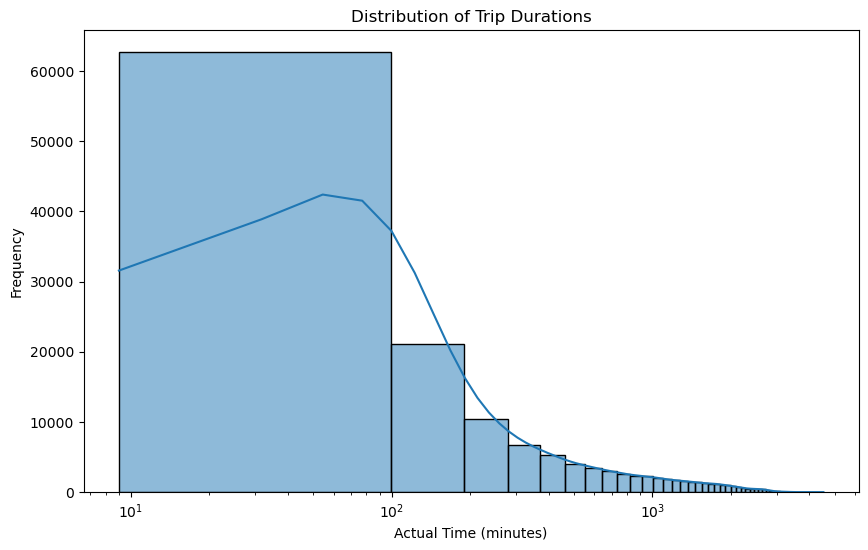

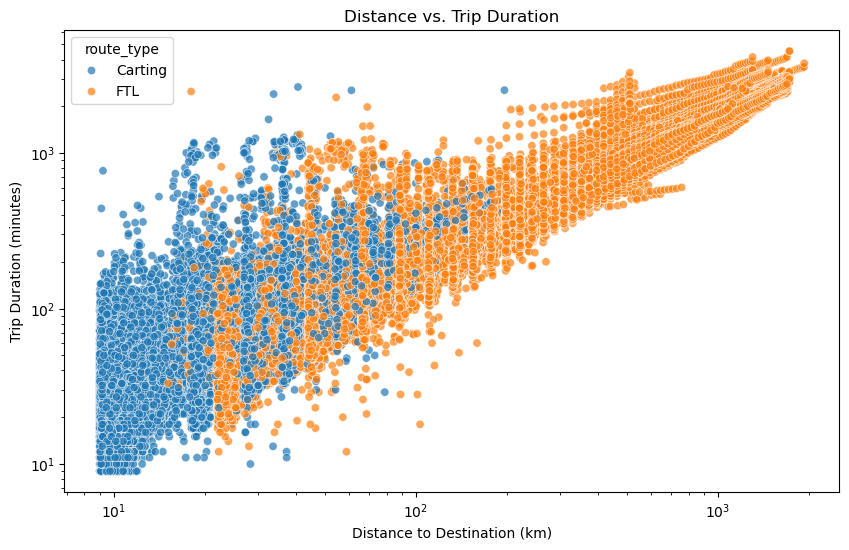

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['actual_time'], bins=50, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Actual Time (minutes)')
plt.ylabel('Frequency')
plt.xscale('log')  # Log scale for better visualization
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='actual_distance_to_destination', y='actual_time', hue='route_type', alpha=0.7)
plt.title('Distance vs. Trip Duration')
plt.xlabel('Distance to Destination (km)')
plt.ylabel('Trip Duration (minutes)')
plt.xscale('log')
plt.yscale('log')
plt.show()

### 5. Efficiency Analysis

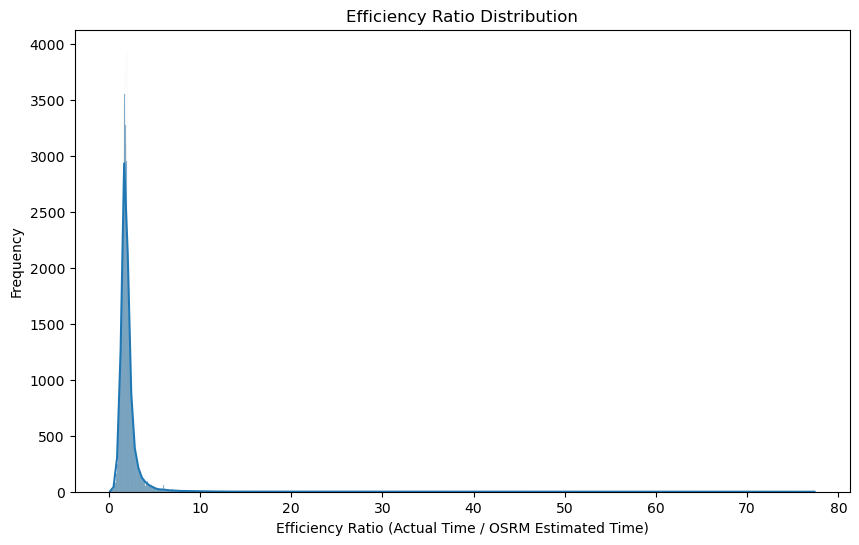


Top Inefficient Routes:
        data          trip_creation_time  \
6   training  2018-09-20 02:35:36.476840   
7   training  2018-09-20 02:35:36.476840   
9   training  2018-09-20 02:35:36.476840   
15  training  2018-09-14 15:42:46.437249   
16  training  2018-09-14 15:42:46.437249   

                                  route_schedule_uuid route_type  \
6   thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
7   thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
9   thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
15  thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...    Carting   
16  thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...    Carting   

                  trip_uuid source_center                    source_name  \
6   trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
7   trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
9   trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat) 

In [5]:
df['efficiency_ratio'] = df['actual_time'] / df['osrm_time']
df = df[df['efficiency_ratio'] > 0]  # Remove invalid ratios

plt.figure(figsize=(10, 6))
sns.histplot(df['efficiency_ratio'], kde=True)
plt.title('Efficiency Ratio Distribution')
plt.xlabel('Efficiency Ratio (Actual Time / OSRM Estimated Time)')
plt.ylabel('Frequency')
plt.show()

# Identify inefficient routes
inefficiency_threshold = 2
inefficient_routes = df[df['efficiency_ratio'] > inefficiency_threshold]
print("\nTop Inefficient Routes:")
print(inefficient_routes.head())

### 6. Clustering for Route Optimization

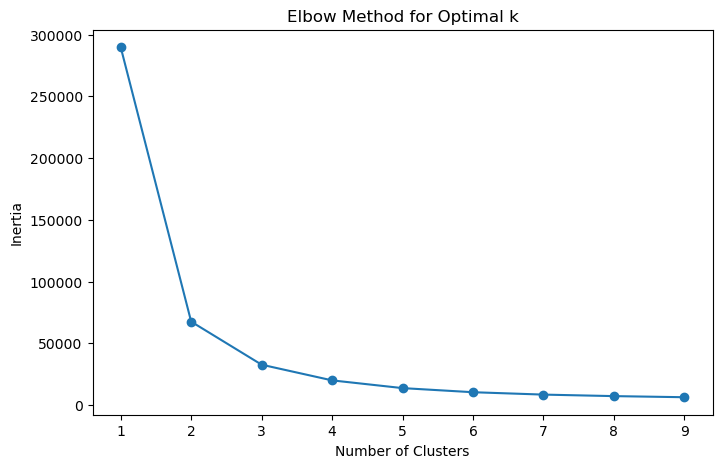

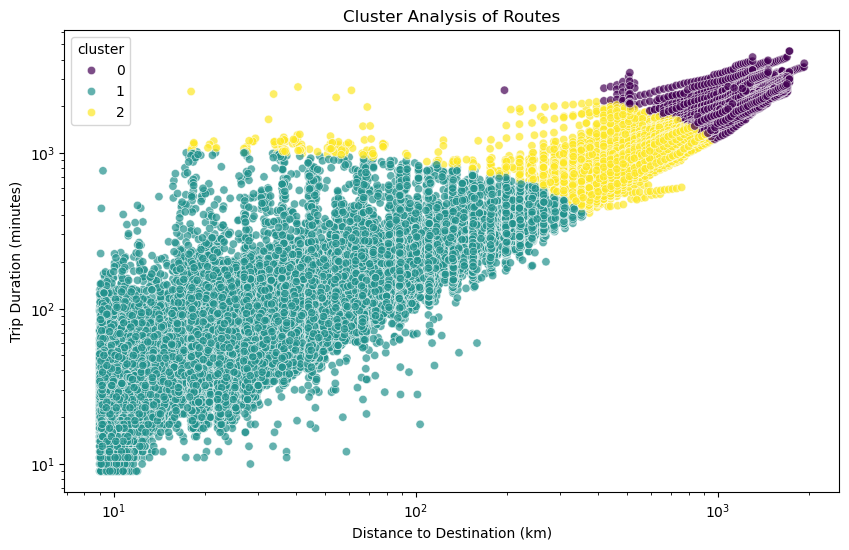

In [6]:
features = df[['actual_distance_to_destination', 'actual_time']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine optimal k using the elbow method
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply KMeans with optimal k (assume 3)
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='actual_distance_to_destination', y='actual_time', hue=df['cluster'], palette='viridis', alpha=0.7)
plt.title('Cluster Analysis of Routes')
plt.xlabel('Distance to Destination (km)')
plt.ylabel('Trip Duration (minutes)')
plt.xscale('log')
plt.yscale('log')
plt.show()

### 7. Optimization Insights

In [7]:
# Function to calculate current average delivery time
def calculate_average_delivery_time(df):
    return df['actual_time'].mean()

# Function to apply optimization
def optimized_delivery_time(df, reduction_percentage=20):
    current_avg_time = calculate_average_delivery_time(df)
    optimized_avg_time = current_avg_time * (1 - reduction_percentage / 100)
    return optimized_avg_time

# Function to estimate cost savings
def estimate_cost_savings(df, time_reduction_percentage=15, distance_reduction_percentage=15):
    time_reduced = df['actual_time'] * (time_reduction_percentage / 100)
    distance_reduced = df['actual_distance_to_destination'] * (distance_reduction_percentage / 100)
    potential_cost_savings = (time_reduced + distance_reduced).sum()
    return potential_cost_savings

# Apply optimization
current_avg_time = calculate_average_delivery_time(df)
optimized_avg_time = optimized_delivery_time(df)
cost_savings = estimate_cost_savings(df)

print(f"Current Avg Delivery Time: {current_avg_time:.2f} minutes")
print(f"Optimized Avg Delivery Time: {optimized_avg_time:.2f} minutes (20% reduction)")
print(f"Estimated Cost Savings: {cost_savings:.2f} units")

Current Avg Delivery Time: 416.93 minutes
Optimized Avg Delivery Time: 333.54 minutes (20% reduction)
Estimated Cost Savings: 14146282.07 units
